# How to use KARABO

In [2]:
from karabo.imaging import imager
from karabo.simulation.telescope import Telescope
from karabo.simulation.observation import Observation
from karabo.simulation.interferometer import InterferometerSimulation
from karabo.simulation.sky_model import SkyModel
from karabo.sourcedetection.result import SourceDetectionResult
from karabo.sourcedetection.evaluation import SourceDetectionEvaluation

# Render plots inline
%matplotlib inline

## Simulation

The sky and telescope simulation is currently provided completely by OSKAR.

We use the built-in GLEAM Sky Catalog for our sky model.

GLEAM_ECG.fits is not downloaded yet. Downloading and caching for future uses...


/home/jennifer/anaconda3/envs/karabo-env/lib/python3.9/site-packages/karabo/simulation/sky_model.py:422: RuntimeWarning: invalid value encountered in log10
  log_flux = np.log10(flux)


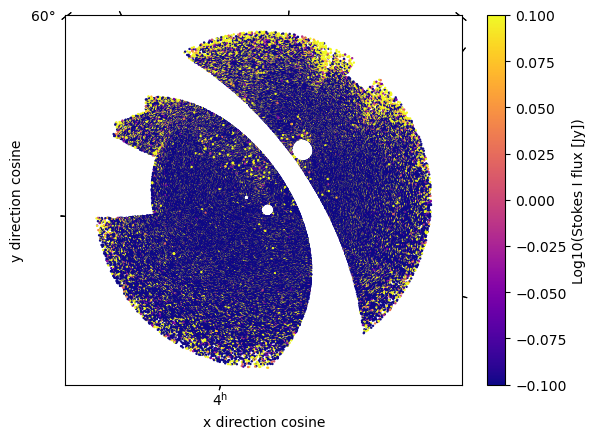

In [3]:
# Get GLEAM Survey Sky
phase_center = [250, -80]  # ra-dec location [degrees]
gleam_sky = SkyModel.get_GLEAM_Sky()
gleam_sky.plot_sky(phase_center)

Then we filter the sky model based on radius.

In [4]:
sky = gleam_sky.filter_by_radius(0, .55, phase_center[0], phase_center[1])
sky.setup_default_wcs(phase_center=phase_center)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---AIR'  'DEC--AIR'  
CRVAL : 250.0  -80.0  
CRPIX : 0.0  0.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -1.0  1.0  
NAXIS : 0  0

Let's have a closer look with the 2d image project explore_sky() provides.

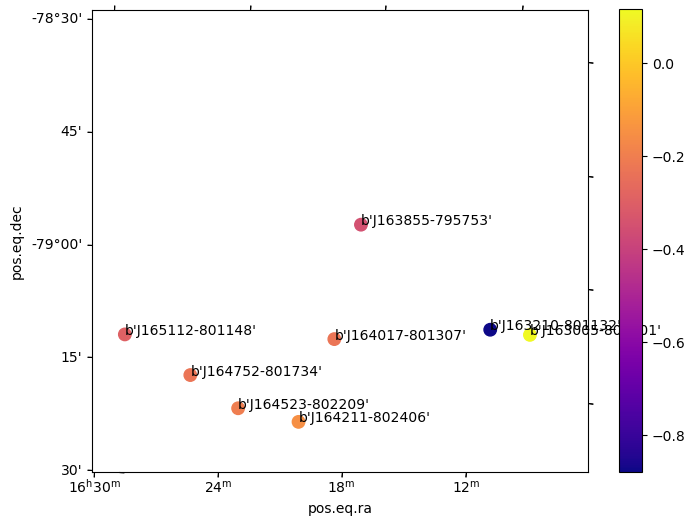

In [5]:
sky.explore_sky(phase_center=phase_center, figsize=(8, 6), s=80,
                xlim=(-.55, .55), ylim=(-.55, .55), with_labels=True)

### Telescope Module

Various observation parameters and meta information `params` must be passed to the telescope module `oskar.Interferometer` of OSKAR as `oskar.SettingsTree`.

In [6]:
askap_tel = Telescope.get_ASKAP_Telescope()
askap_tel.plot_telescope()

FileNotFoundError: [Errno 2] No such file or directory: '/home/jennifer/anaconda3/envs/karabo-env/lib/python3.9/site-packages/karabo/data/askap.tm'

### Observation Simulation

Now the sky module must be passed to the interferometer and the simulation of the observation must be started to generate the measurement set.

In [10]:
observation_settings = Observation(100e6,
                                        phase_centre_ra_deg=phase_center[0],
                                        phase_centre_dec_deg=phase_center[1],
                                        number_of_channels=64,
                                        number_of_time_steps=24)

interferometer_sim = InterferometerSimulation(channel_bandwidth_hz=1e6)
visibility_askap = interferometer_sim.run_simulation(askap_tel, sky, observation_settings)

W|                                                                   
W|== WARNING: No GPU capability available.
W|                                                                   


### Dirty Images

We can create dirty images of visibilites and display them as shown below

WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'STOKES'  'FREQ'  
CRVAL : 250.0  -80.0  1.0  100000000.0  
CRPIX : 1025.0  1025.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.0022222222222222  0.0022222222222222  1.0  1.0  
NAXIS : 2048  2048  1  64


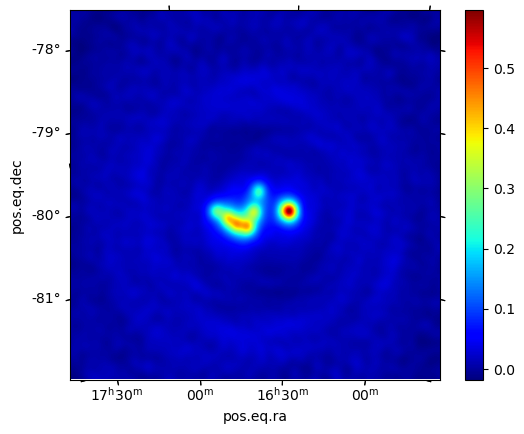

In [11]:
imager_askap = imager.Imager(visibility_askap, imaging_npixel=2048,
                             imaging_cellsize=3.878509448876288e-05)
dirty = imager_askap.get_dirty_image()
dirty.plot()

### Imaging

In [12]:
imager_askap.ingest_chan_per_blockvis = 1
imager_askap.ingest_vis_nchan = 16

deconvolved, restored, residual = imager_askap.imaging_rascil(
    clean_nmajor=0,
    clean_algorithm='mmclean',
    clean_scales=[0, 6, 10, 30, 60],
    clean_fractional_threshold=.3,
    clean_threshold=.12e-3,
    clean_nmoment=5,
    clean_psf_support=640,
    clean_restored_output='integrated')

Client Dashboard Address: http://127.0.0.1:8787/status
LocalCluster(0a4db42b, 'tcp://127.0.0.1:42667', workers=5, threads=5, memory=31.19 GiB)


WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'STOKES'  'FREQ'  
CRVAL : 250.0  -80.0  1.0  100000000.0  
CRPIX : 1025.0  1025.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.0022222222222222  0.0022222222222222  1.0  1.0  
NAXIS : 2048  2048  1  16


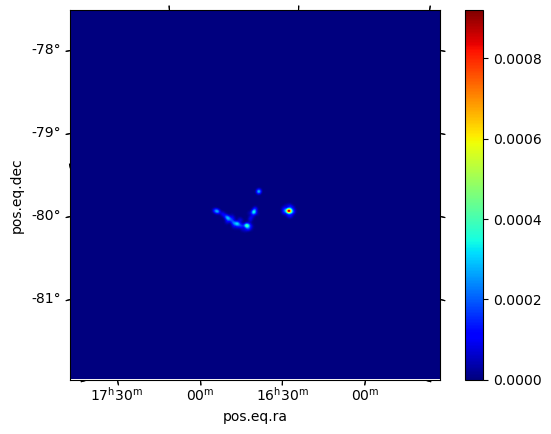

In [17]:
# Any of the resulting output images of the CLEAN algorithm can be displayed and saved.
deconvolved.plot()

## Analysis via Source Detection

Source Detection on restored image.

In [18]:
detection_result = SourceDetectionResult.detect_sources_in_image(restored)

--> Opened '/home/vincenzo/Karabo-Pipeline/karabo/examples/.tmp/485de941-d915-438e-85d7-0b3b158bb074'
Image size .............................. : (2048, 2048) pixels
Number of channels ...................... : 1
Number of Stokes parameters ............. : 1
Beam shape (major, minor, pos angle) .... : (6.89535e-02, 6.34962e-02, 0.1) degrees
Frequency of image ...................... : 100.000 MHz
Number of blank pixels .................. : 0 (0.0%)
Flux from sum of (non-blank) pixels ..... : 29.987 Jy
--> Calculating background rms and mean images
Derived rms_box (box size, step size) ... : (2751, 205) pixels
--> Size of rms_box larger than 1/4 of image size
--> Using constant background rms and mean
Value of background rms ................. : 3.20e-03 Jy/beam
Value of background mean ................ : 0.00412 Jy/beam
--> Expected 5-sigma-clipped false detection rate < fdr_ratio
--> Using sigma-clipping ('hard') thresholding
Minimum number of pixels per island ..... : 334
Number of isla

Fitting islands with Gaussians .......... : [|] 0/1Fitting islands with Gaussians .......... : [] 1/1[-3G

Total number of Gaussians fit to image .. : 11
Total flux density in model ............. : 8.253 Jy


--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 4


--> Wrote ASCII file '/home/vincenzo/Karabo-Pipeline/karabo/examples/.tmp/d12b1de5-73f1-43c5-ba87-defb1ed7da41'
--> Wrote file '/home/vincenzo/Karabo-Pipeline/karabo/examples/.tmp/ca01b6ea-8393-434b-8e3a-9570edb6cf89'


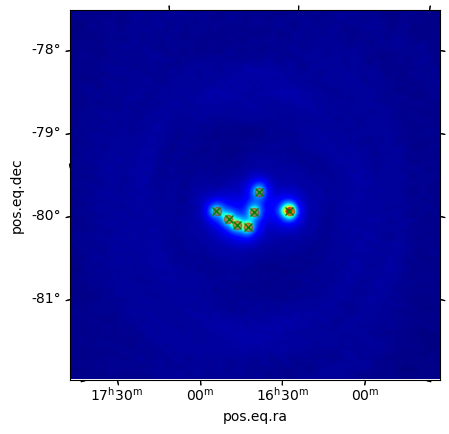

In [24]:
mapping = SourceDetectionEvaluation.evaluate_result_with_sky_in_pixel_space(detection_result, sky, 10)
mapping.plot()